In [6]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [68]:
#python -m spacy download ru_core_news_lg

In [1]:
import pandas as pd
import torch
import re
import spacy
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
tqdm.pandas()

/home/emiliia/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Загрузка данных

In [2]:
# Загрузка данных
df_train = pd.read_csv("files_rtf.csv")
df_test = pd.read_csv('sample.csv').dropna()
df_resh = pd.read_csv("resh.csv")

# Объединение датасетов
df_combined = pd.concat([df_train, df_test, df_resh], ignore_index=True)
df = df.drop('Unnamed: 0', axis=1)

# Перемешивание данных
df = df_combined.sample(frac=1, random_state=777).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   1210 non-null   object
 1   text    1210 non-null   object
dtypes: object(2)
memory usage: 19.0+ KB


## Ключевые слова

In [4]:
# Функция для очистки текста от знаков препинания
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Zа-яА-Я]', ' ', text)

# Группировка данных по классам
grouped = df.groupby('class')['text'].apply(lambda x: ' '.join(x))

# Создание списка уникальных слов для каждого класса
unique_words_by_class = {}
for class_name, text in grouped.items():
    # Очистка текста от знаков препинания
    text = remove_punctuation(text)
    words = set(text.lower().split())  # Преобразуем текст в нижний регистр и разбиваем на слова
    unique_words_by_class[class_name] = words

# Создание словаря с количеством классов, в которых встречается каждое слово
word_class_count = {}
for class_name, unique_words in unique_words_by_class.items():
    for word in unique_words:
        word_class_count[word] = word_class_count.get(word, 0) + 1

# Выбор только тех слов, которые встречаются только в одном классе
unique_words_only_by_one_class = {word: class_count for word, class_count in word_class_count.items() if class_count == 1}

# Создание топ-10 уникальных слов для каждого класса
top_unique_words_by_class = {}
for class_name, unique_words in unique_words_by_class.items():
    word_counts = Counter()
    for text in df[df['class'] == class_name]['text']:
        # Очистка текста от знаков препинания
        text = remove_punctuation(text)
        words = set(text.lower().split())
        # Увеличение счетчика на 1 для каждого слова из текста, если оно есть в списке уникальных слов для данного класса
        word_counts.update(word for word in words if word in unique_words_only_by_one_class)
    top_unique_words = [word for word, _ in word_counts.most_common(10)]
    top_unique_words_by_class[class_name] = word_counts

In [5]:
# Вывод топ-10 уникальных слов для каждого класса
for class_name, top_unique_words in top_unique_words_by_class.items():
    print(f"Топ-10 уникальных слов для класса '{class_name}':")
    print(', '.join([word for word, _ in top_unique_words.most_common(10)]))
    print()

Топ-10 уникальных слов для класса 'act':
подписав, подтверждаем, инв, счетчика, романовича, lenovo, lg, девятьсот, ивановной, захарова

Топ-10 уникальных слов для класса 'application':
бальмонт, викторовичу, денисову, кургана, красина, сотового, прописки, пмж, денису, курганского

Топ-10 уникальных слов для класса 'arrangement':
локальными, уведомительной, освобожденным, заработок, локальном, вредным, заменена, высвобождаемым, отраслевая, удобное

Топ-10 уникальных слов для класса 'bill':
предъявляемая, вo, cnr, gmbh, trier, deutschland, metternichstra, бодрость, наметкина, говая

Топ-10 уникальных слов для класса 'contract':
преступлением, ялуторовск, пеня, просроченный, сопроводить, осуждено, деяния, преступление, договаривающаяся, договаривающейся

Топ-10 уникальных слов для класса 'contract offer':
безоговорочное, адресованное, нижеприведенные, заказанного, понимает, ссылаться, оплаченный, безоговорочного, рассылок, публичную

Топ-10 уникальных слов для класса 'determination':
засл

In [6]:
# уберём неинтересные слова
words_to_remove = ['тринадцатого', 'ь', 'артемьеву', 'михайловичу', 'григорию', 'михайловичу']
for word in words_to_remove:
    top_unique_words_by_class['proxy'].pop(word, None)

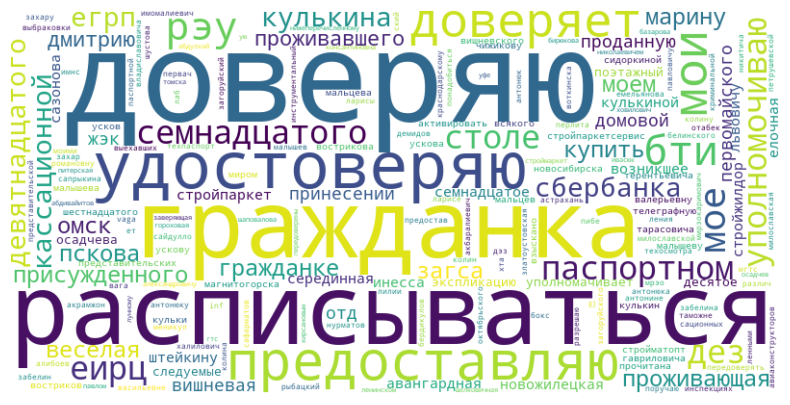

In [7]:
# Создание облака слов для класса 'Доверенность'
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=9).generate_from_frequencies(top_unique_words_by_class['proxy'])

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Распределение слов 

In [16]:
def build_hist(data, title, yaxis_title, xaxis_title):
      fig = px.histogram(data,
                        template='plotly_dark',
                        height=600,
                        #nbins=150
                        )

      fig.update_layout(yaxis_title=yaxis_title, 
                        xaxis_title=xaxis_title,
                        title={'text': title,
                              'y':0.95,
                              'x':0.5},
                        showlegend=False)

      fig.show()

In [17]:
def build_bar(data, x, y, title, yaxis_title, xaxis_title):
      fig = px.bar(data,
                  x = x,
                  y = y, 
                  template='plotly_dark',
                  height=700,
                  )

      fig.update_layout(yaxis_title=yaxis_title, 
                        xaxis_title=xaxis_title,
                        title={'text': title,
                              'y':0.95,
                              'x':0.5},
                        showlegend=False)

      fig.show()

In [18]:
def build_box(data, x, y, title, yaxis_title, xaxis_title):
      fig = px.box(data, 
                  x = x,
                  y = y, 
                  points='all',
                  template='plotly_dark',
                  height=600,
                  )

      fig.update_layout(yaxis_title=yaxis_title, 
                        xaxis_title=xaxis_title,
                        title={'text': title,
                              'y':0.95,
                              'x':0.5},
                        showlegend=False)

      fig.show()


In [19]:
def build_scatter(data, projections, title):
    fig = px.scatter(projections,
                x=0, 
                y=1,
                color=data['class'], 
                labels={'color': 'Класс отзыва'},
                template='plotly_dark',
                height=700,
                )
 

    fig.update_layout(
                title={'text': title,
                        'y':0.95,
                        'x':0.5},
                showlegend=True)

    fig.show()

In [20]:
def build_scatter_3d(data, projections, title):
    fig = px.scatter_3d(projections,
                x=0, 
                y=1,
                z=2,
                opacity=0.5,
                color=data['class'], 
                labels={'color': 'Класс отзыва'},
                template='plotly_dark',
                height=700,
                )
 

    fig.update_layout(
                title={'text': title,
                        'y':0.95,
                        'x':0.5},
                showlegend=True)

    fig.show()

Построим столбчатую диаграмма для визуализации распределения классов.          

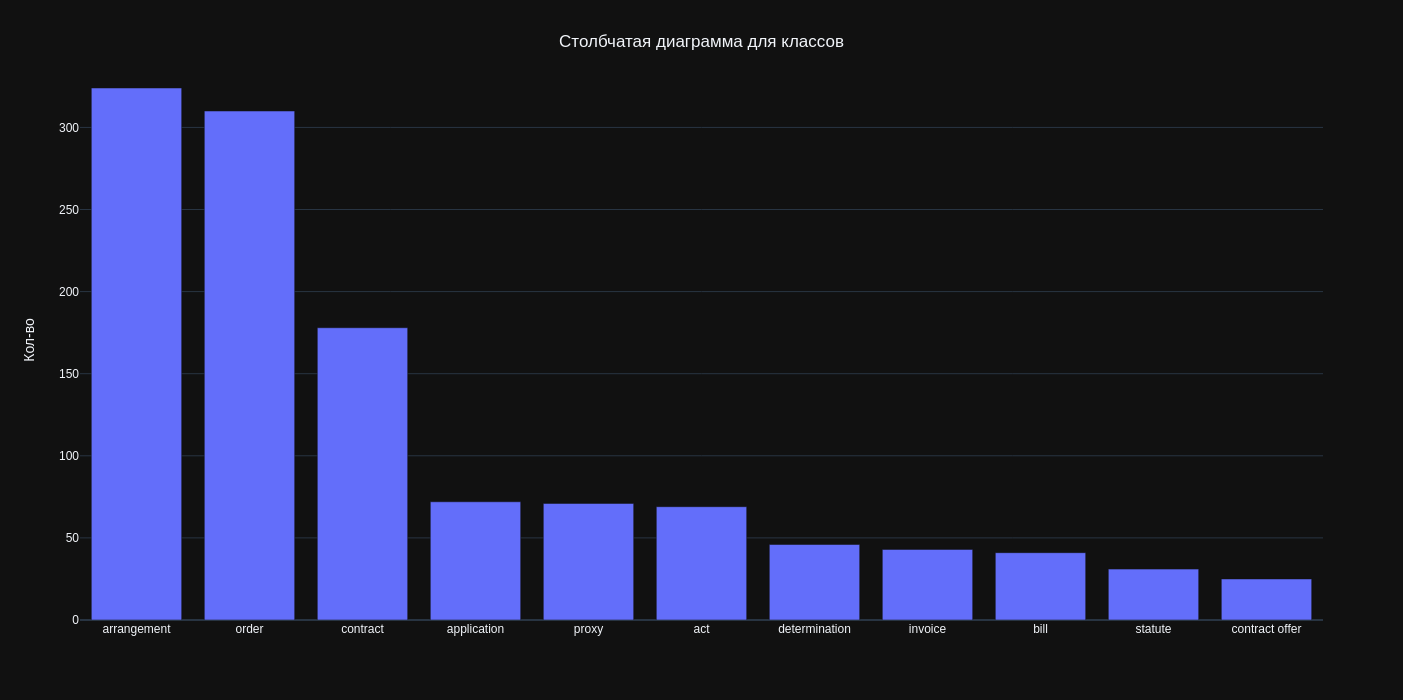

In [21]:
class_distribution = df['class'].value_counts().reset_index()
class_distribution.columns = ['class', 'count']
build_bar(class_distribution, 'class', 'count', 'Столбчатая диаграмма для классов', ' Кол-во', '')

Построим гистограмму для визуализации распределения количества слов.

In [22]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(lambda x: len(x))

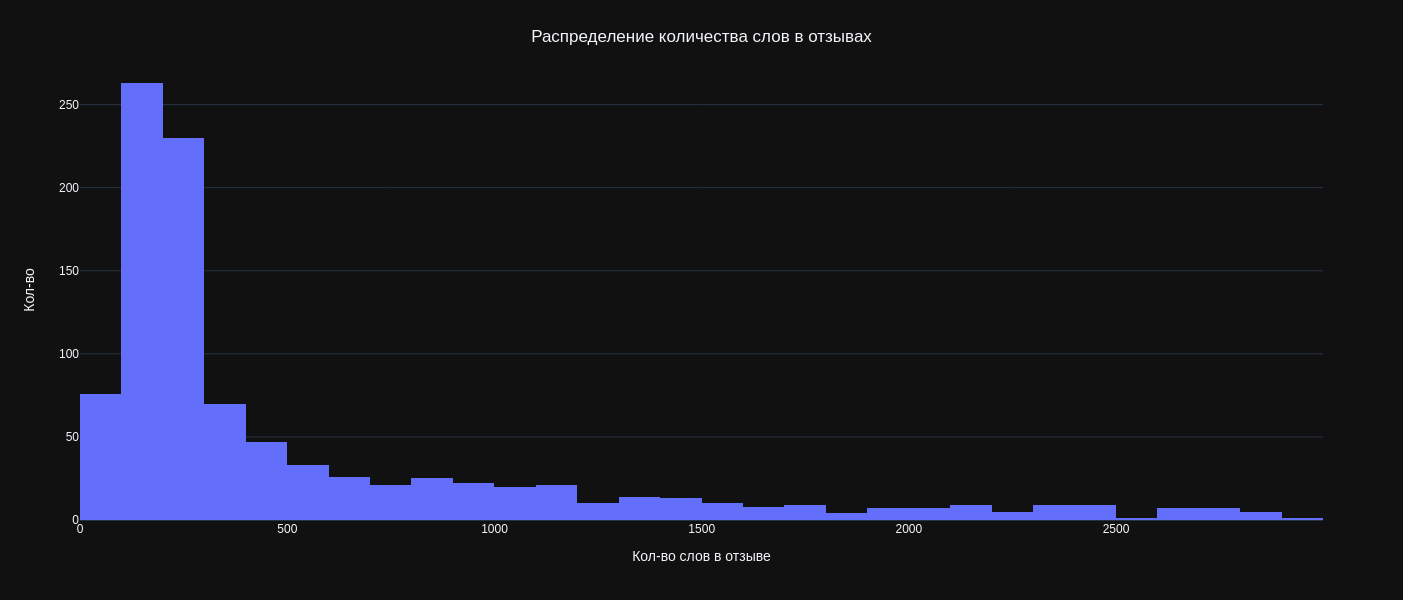

In [36]:
build_hist(df[df['word_count'] < 3000]['word_count'], 'Распределение количества слов в отзывах', 'Кол-во', 'Кол-во слов в отзыве')

Аналогично пострим гистограммy для визуализации распределения количества символов. 

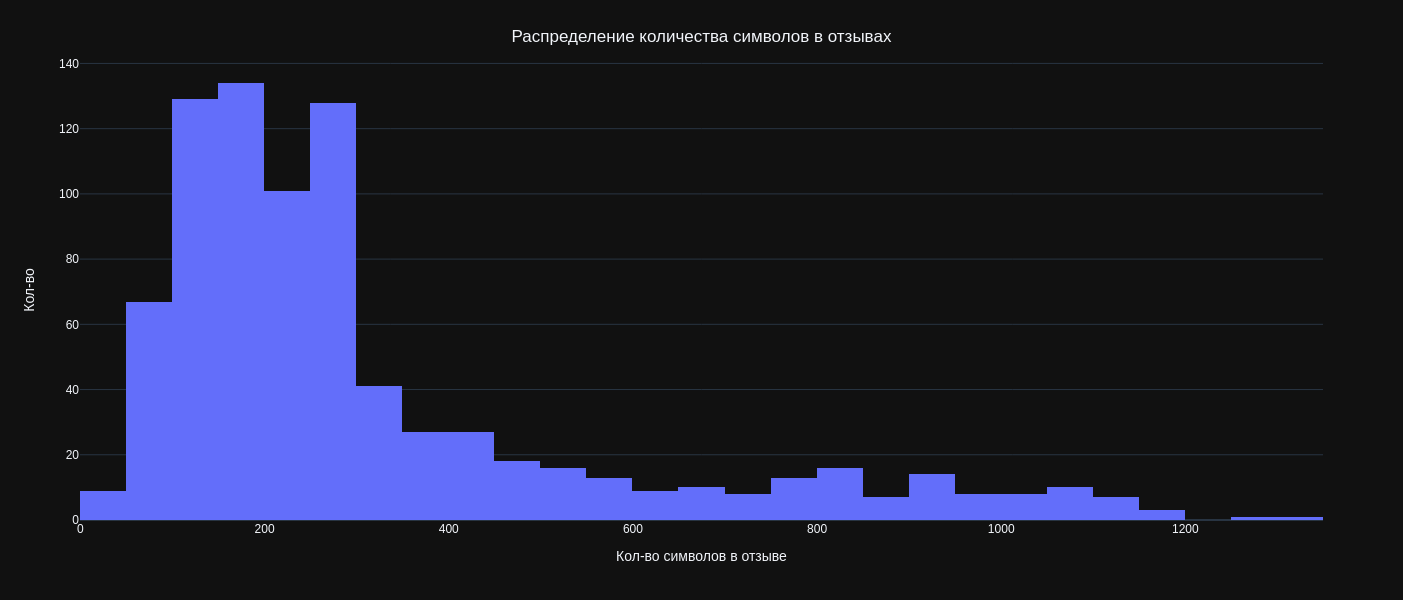

In [32]:
build_hist(df[df['char_count'] < 10000]['word_count'], 'Распределение количества символов в отзывах', 'Кол-во', 'Кол-во символов в отзыве')

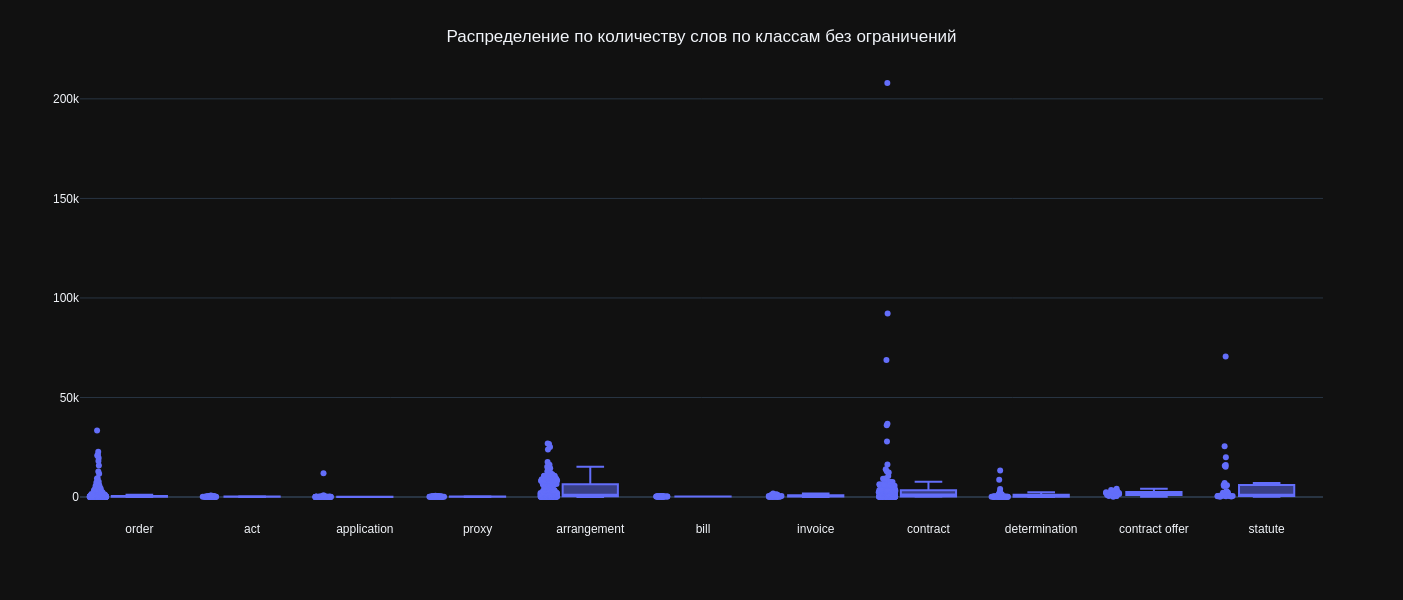

In [38]:
build_box(df, 'class', 'word_count', 'Распределение по количеству слов по классам без ограничений', '', '')

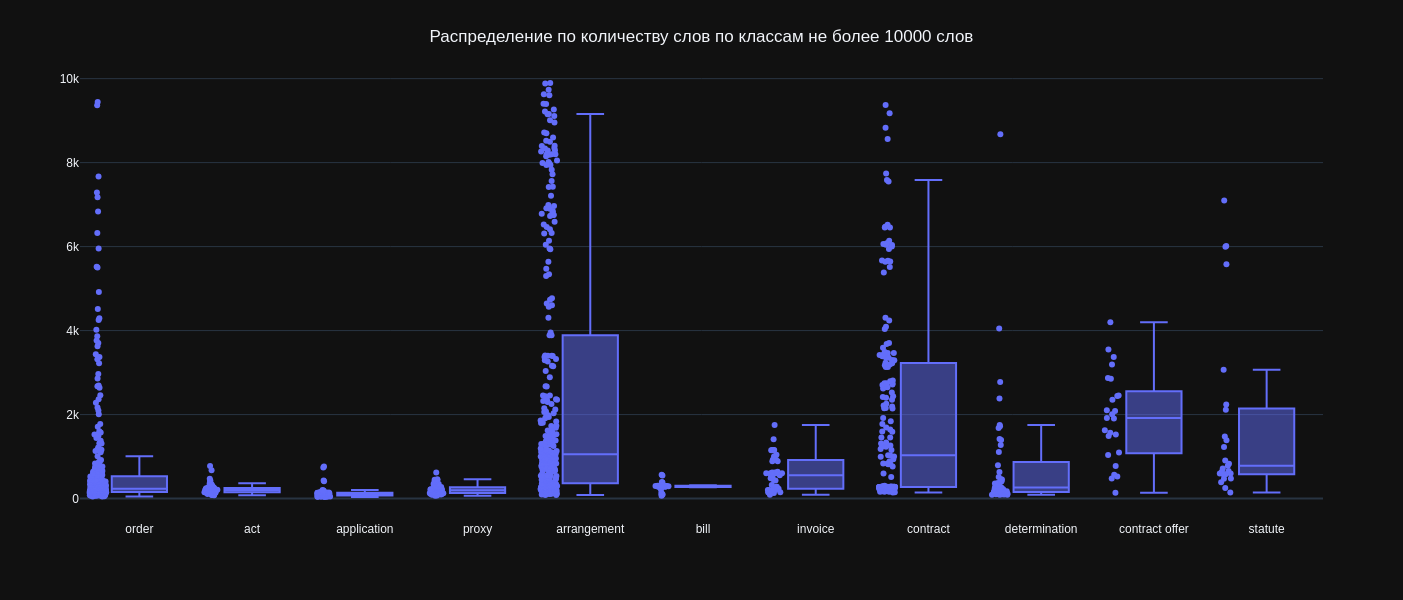

In [48]:
build_box(df[df['word_count'] < 10000], 'class', 'word_count', 'Распределение по количеству слов по классам не более 10000 слов', '', '')

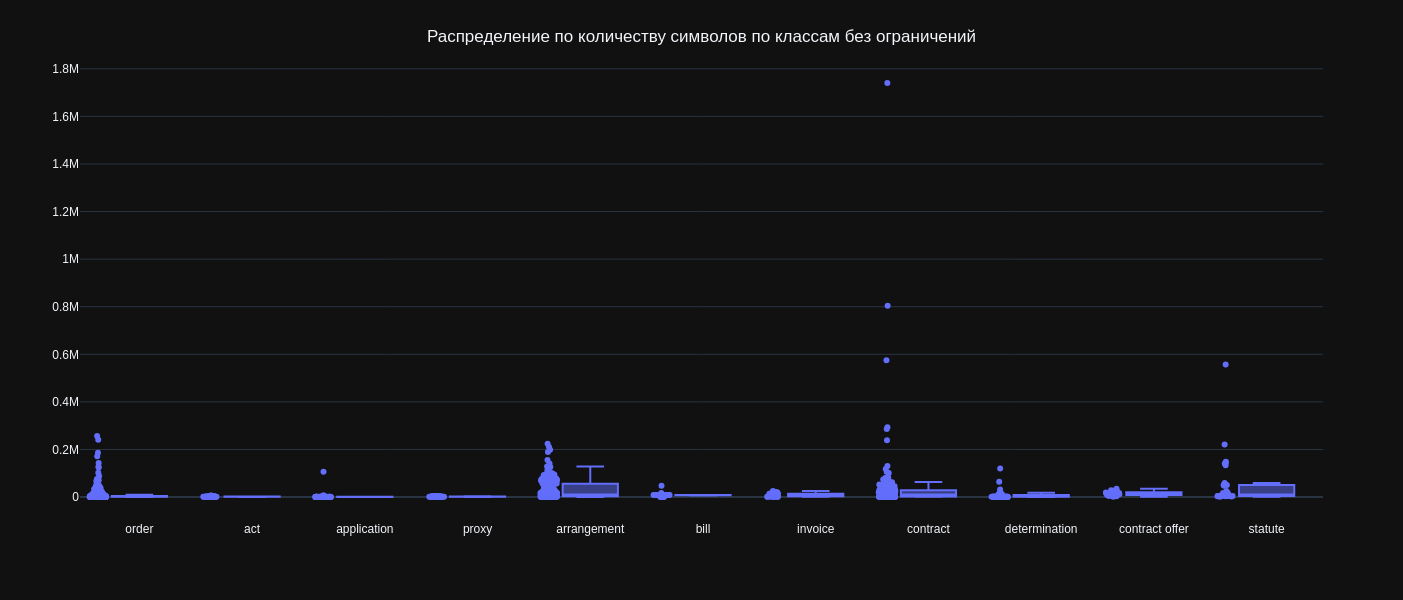

In [41]:
build_box(df, 'class', 'char_count', 'Распределение по количеству символов по классам без ограничений', '', '')

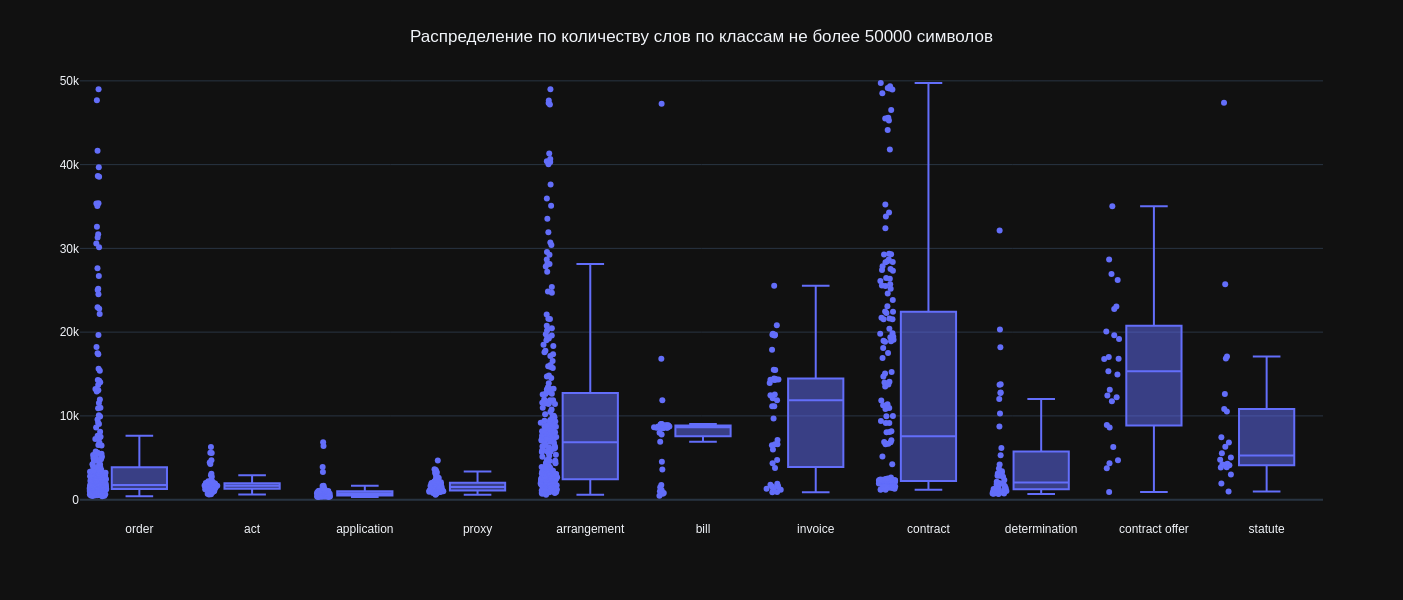

In [47]:
build_box(df[df['char_count'] < 50000], 'class', 'char_count', 'Распределение по количеству слов по классам не более 50000 символов', '', '')

## Классы в пространстве эмбеддингов

Создадим класс-хранилище эмбеддингов

In [49]:
class VectorStore:
    def __init__(self, model, size):
        self.documents = []
        self.embeddings = np.empty(size)
        self.model = model  

    def add_to_store(self, document):
        self.documents.append(document)
        embedding = self.model.encode(document, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False, batch_size=32)
        self.embeddings = np.vstack((self.embeddings, embedding))

Для получения эмбеддингов воспользуемся моделью MiniLM-L12-v2

In [50]:
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'

In [51]:
model_name = model_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Для получения эмбеддинга на текст будем использовать CLS-токен

In [52]:
model = SentenceTransformer(model_name, device=device)
model[1].pooling_mode_mean_tokens = False
model[1].pooling_mode_cls_token = True
model

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

/home/emiliia/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

/home/emiliia/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.



model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [53]:
store = VectorStore(model, size=(0, model[1].word_embedding_dimension)) 
for i in tqdm(range(df.shape[0])):
    store.add_to_store(df['text'][i])

100%|███████████████████████████████████████| 1210/1210 [00:23<00:00, 52.35it/s]


In [54]:
store.embeddings.shape

(1210, 384)

Для уменьшения размерности воспользуемся сначала tsne (t-distributed Stochastic Neighbor Embedding)

In [55]:
tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(store.embeddings)

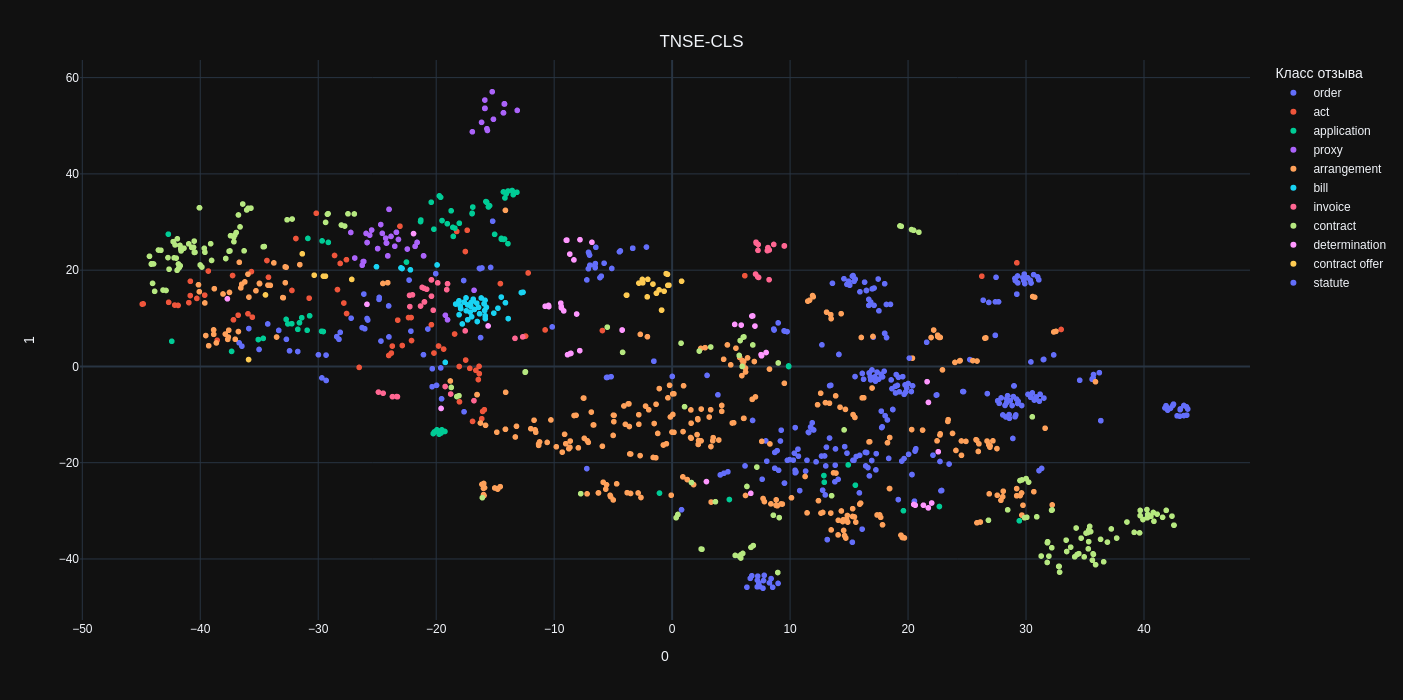

In [56]:
build_scatter(df, projections, 'TNSE-CLS')

Посмотрим, как изменится визуализация при использовании umap(Uniform Manifold Approximation and Projection)

In [57]:
umap_model = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42, n_components=2)
projections = umap_model.fit_transform(store.embeddings)

/home/emiliia/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



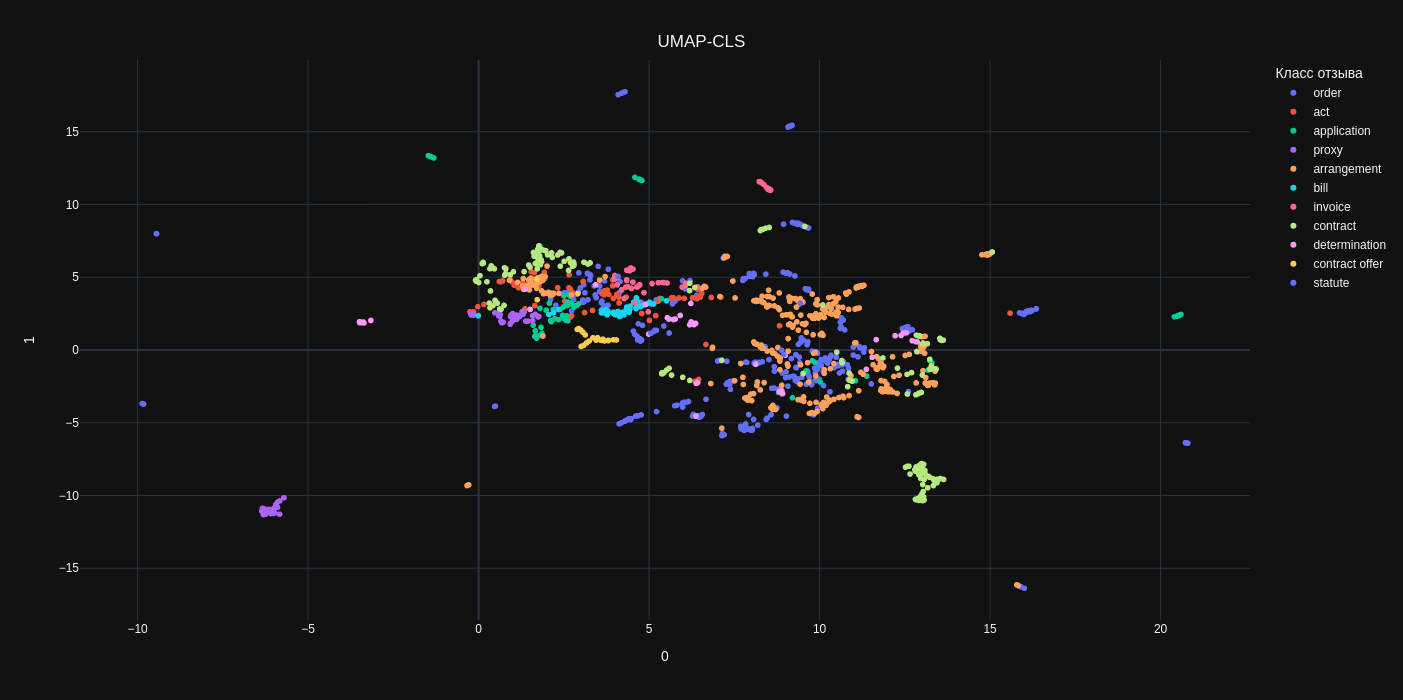

In [58]:
build_scatter(df, projections, 'UMAP-CLS')

Для наглядности пострим трехмерную визуализацию

In [59]:
umap_model = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42, n_components=3)
projections = umap_model.fit_transform(store.embeddings)

/home/emiliia/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



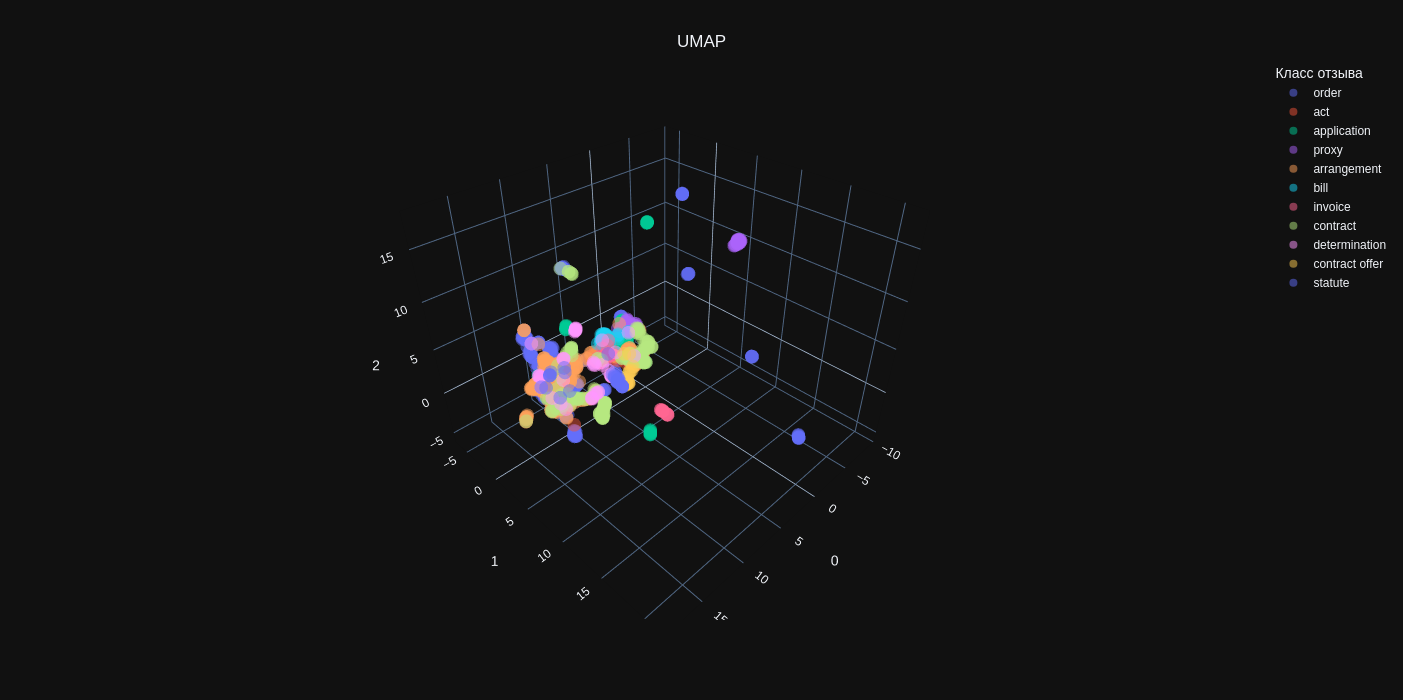

In [60]:
build_scatter_3d(df, projections, 'UMAP')

Изменим пулинг-метод с CLS на mean

In [61]:
model[1].pooling_mode_mean_tokens = True
model[1].pooling_mode_cls_token = False
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [62]:
store = VectorStore(model, size=(0, model[1].word_embedding_dimension)) 
for i in tqdm(range(df.shape[0])):
    store.add_to_store(df['text'][i])

100%|███████████████████████████████████████| 1210/1210 [00:22<00:00, 54.51it/s]


Для визуализации будем использовать только UMAP

In [63]:
umap_model = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42, n_components=2)
projections = umap_model.fit_transform(store.embeddings)

/home/emiliia/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



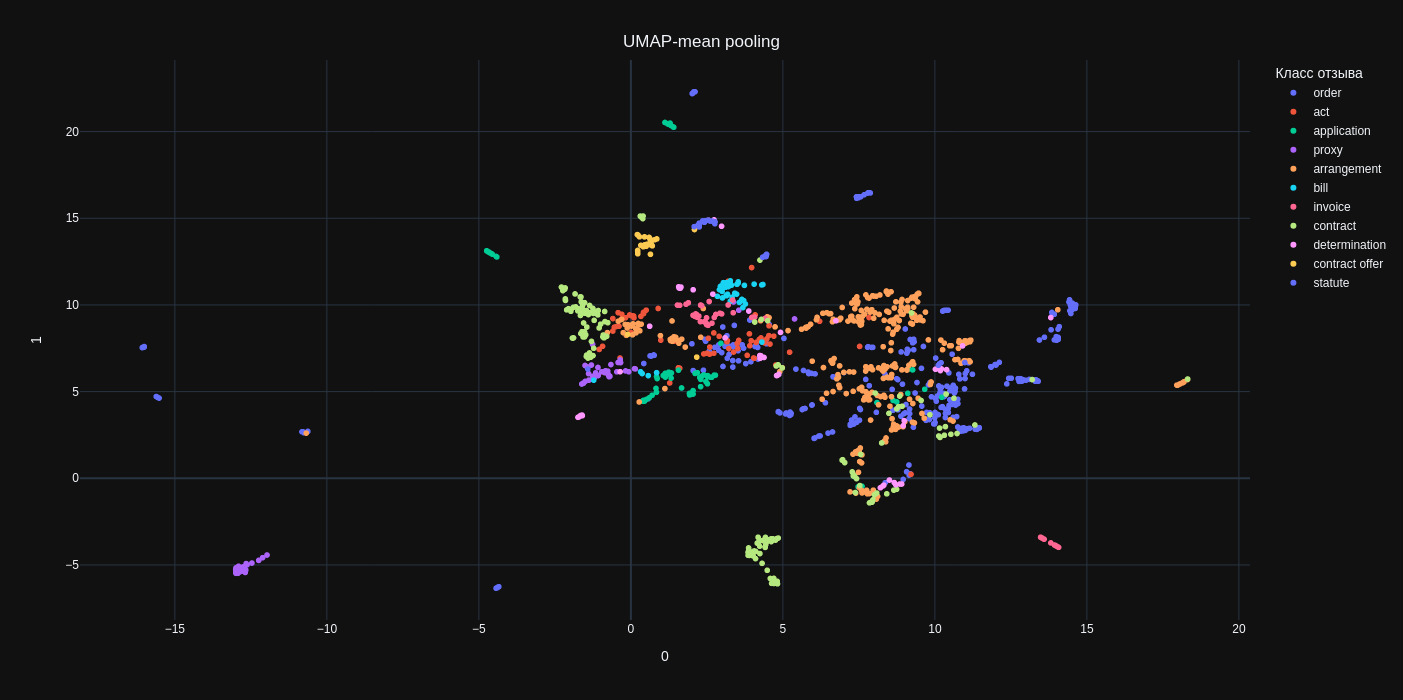

In [64]:
build_scatter(df, projections, 'UMAP-mean pooling')

Ожидаемо при использовании mean pooling эмбеддинги текстов формируют менее выраженные группы кластеров, чем при использовании CSL токена.

Посмотрим, как изменится картина при использовании TF-IDF для получения эмбеддингов. Для очистки тестов воспользуемся библиотекой spacy и больщую модель для русского языка.

In [71]:
nlp = spacy.load("ru_core_news_lg", exclude=['tok2vec', 'morphologizer', 
                                             'parser', 'attribute_ruler', 'ner'])
nlp.max_length = 2000000

In [72]:
df['text_doc'] = list(nlp.pipe(df['text'], n_process=3, batch_size=512))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [73]:
def lemmatize(doc):
    words = []
    for token in doc:
        if (token.is_stop != True) and (token.is_punct != True) and\
            (token.is_space != True) and (token.is_digit != True):
            words.append(token.lemma_)
    return ' '.join(words)

In [74]:
df['clear_text'] = df['text_doc'].progress_apply(lemmatize)

100%|█████████████████████████████████████| 1210/1210 [00:01<00:00, 1011.51it/s]


In [75]:
df.sample(3)

,class,text,word_count,char_count,text_doc,clear_text
1187,proxy,Д О В Е Р Е Н Н О С Т Ь\nг. Марс\nПервого янва...,281,2046,"(Д, О, В, Е, Р, Е, Н, Н, О, С, Т, Ь, \n, г., М...",Т ь г. марс Первого январь два тысяча тринадца...
1162,bill,\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,303,8855,(\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\...,приложение № постановление правительство росси...
274,arrangement,СОГЛАШЕНИЕ\n\nОБ ОРГАНИЗАЦИИ ЭЛЕКТРОННОГО ВЗАИ...,940,8183,"(СОГЛАШЕНИЕ, \n\n, ОБ, ОРГАНИЗАЦИИ, ЭЛЕКТРОННО...",соглашение организация электронный взаимодейст...


In [76]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clear_text'])

In [77]:
X.shape

(1210, 25712)

In [78]:
umap_model = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', n_jobs=-1, n_components=2)
projections = umap_model.fit_transform(X)

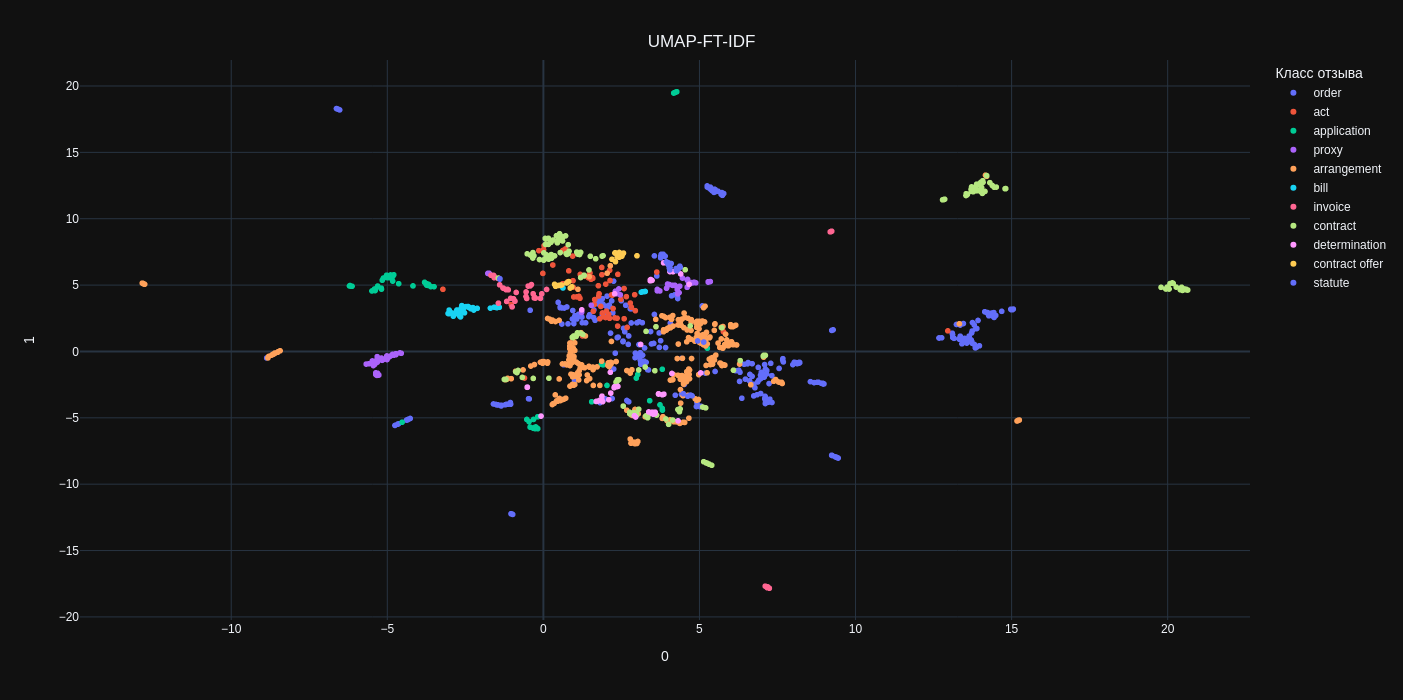

In [79]:
build_scatter(df, projections, 'UMAP-FT-IDF')